In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Gather datasets

In [4]:
data = pd.read_pickle('saved-metrics.pkl')


In [5]:
metric2 = data[data.type==2].fillna(0)

metric_list = list(metric2.columns.drop('total biomass'))


# Plot all possible metrics vs biomass

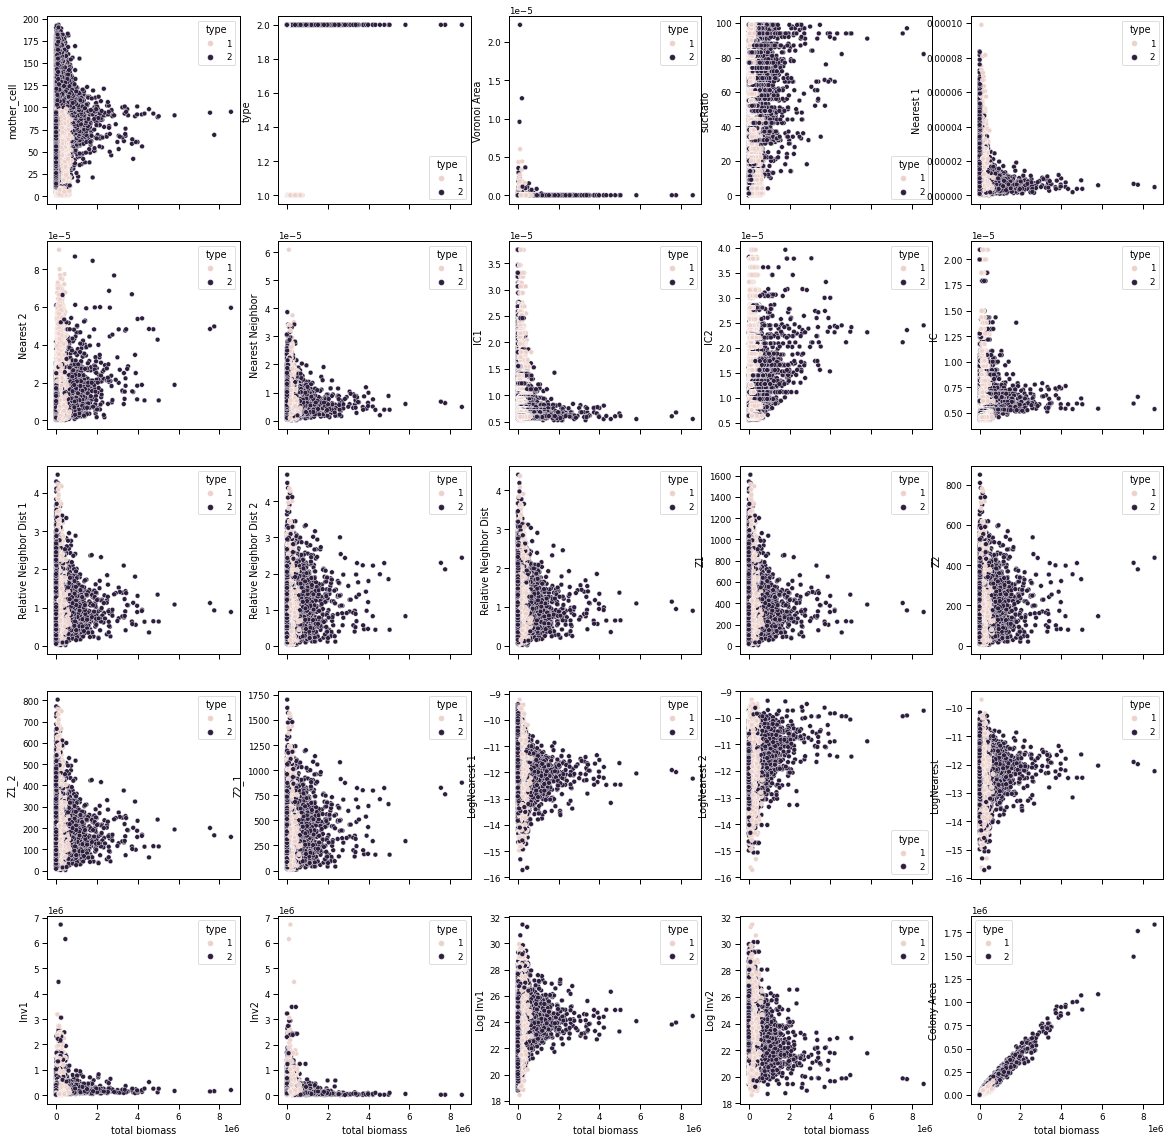

In [6]:
sns.set_context('paper')
f, axes = plt.subplots(nrows = int(np.sqrt(len(metric_list))),ncols=int(np.sqrt(len(metric_list))),figsize=(20,20),sharex=True)
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
plt.show()
#for ax in axes.ravel():
   # ax.set_xscale('log')
   # ax.set_yscale('log')


In [319]:
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell','Relative Neighbor Dist','Relative Neighbor Dist 1','Relative Neighbor Dist 2',
'Z1_2','Z2_1','LogNearest','LogNearest 1','LogNearest 2','Log Inv1','Log Inv2','Nearest 1','Nearest 2',]))
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
#X = sm.add_constant(X)

# Split data into fitting and testing groups

In [320]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 42)

# Preliminary model fitting

In [321]:
model = sm.OLS(train_y, train_X)
model = model.fit()
print(model.summary2())

                                     Results: Ordinary least squares
Model:                           OLS                          Adj. R-squared:                 0.532      
Dependent Variable:              total biomass                AIC:                            980335.1860
Date:                            2021-09-20 13:21             BIC:                            980428.8162
No. Observations:                36748                        Log-Likelihood:                 -4.9016e+05
Df Model:                        10                           F-statistic:                    4178.      
Df Residuals:                    36737                        Prob (F-statistic):             0.00       
R-squared:                       0.532                        Scale:                          2.2551e+10 
---------------------------------------------------------------------------------------------------------
                       Coef.            Std.Err.       t     P>|t|        [0.025   

# Define backward regression algorithm

In [322]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y,X[included]).fit()
        pvalues = model.pvalues
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included,model
threshold = 0.0001

# Perform backward regression to find the best fitting parameters

In [323]:
#stats = list(data.columns.drop(['total biomass','Colony Area']))
reg_mets,model = backward_regression(train_X, train_y, threshold_out=threshold,
                           verbose=True)
reg_mets

Drop Voronoi Area                   with p-value 0.975589
Drop Inv2                           with p-value 0.488006


['type',
 'sucRatio',
 'Nearest Neighbor',
 'IC1',
 'IC2',
 'IC',
 'Z1',
 'Z2',
 'Inv1']

# Check the resulting fit

In [324]:
predictions = model.predict(test_X[reg_mets])
df_results = pd.DataFrame({'Actual' : test_y, 'Predicted': predictions})

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     5222.
Date:                Mon, 20 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:21:28   Log-Likelihood:            -4.9016e+05
No. Observations:               36748   AIC:                         9.803e+05
Df Residuals:                   36739   BIC:                         9.804e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
type              1.998e+04   3190.729  

In [325]:
from sklearn.metrics import r2_score, mean_squared_error
RMSE = np.sqrt(mean_squared_error(test_y, predictions))
r2 = r2_score(test_y, predictions)
print(RMSE, r2)

137652.63481958504 0.5560706631194348


# Evaluate resulting model

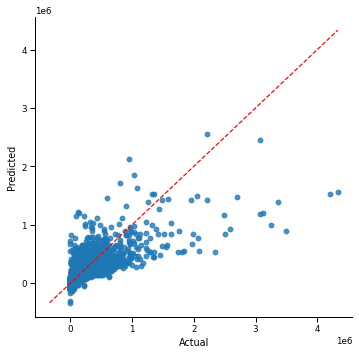

In [326]:
#Plot the actual vs predicted results
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
#Plot the diagonal line
d_line= np.arange(df_results.min().min(), df_results.max().max())
plt.plot(d_line, d_line, color='red', linestyle='--')
plt.show()

# Check that the residuals are normally distributed

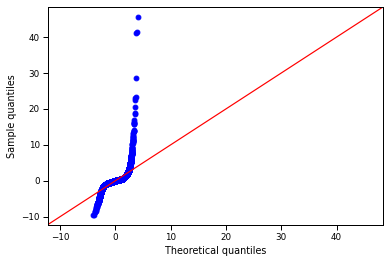

In [327]:
from statsmodels.graphics.gofplots import qqplot
fig=qqplot(model.resid_pearson,line='45',fit='True')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

C:\Users\Jonathan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


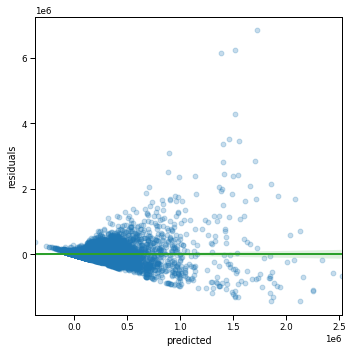

In [328]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(model.fittedvalues,model.resid, scatter_kws={'alpha': 0.25}, line_kws={'color': 'C2', 'lw': 2}, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('residuals')
plt.tight_layout()
plt.show()

# Durbin-Watson test for autocorrelation

In [329]:
from statsmodels.stats.stattools import durbin_watson
durbinWatson = durbin_watson(model.resid)
print(durbinWatson)

1.9931294422911778


<AxesSubplot:>

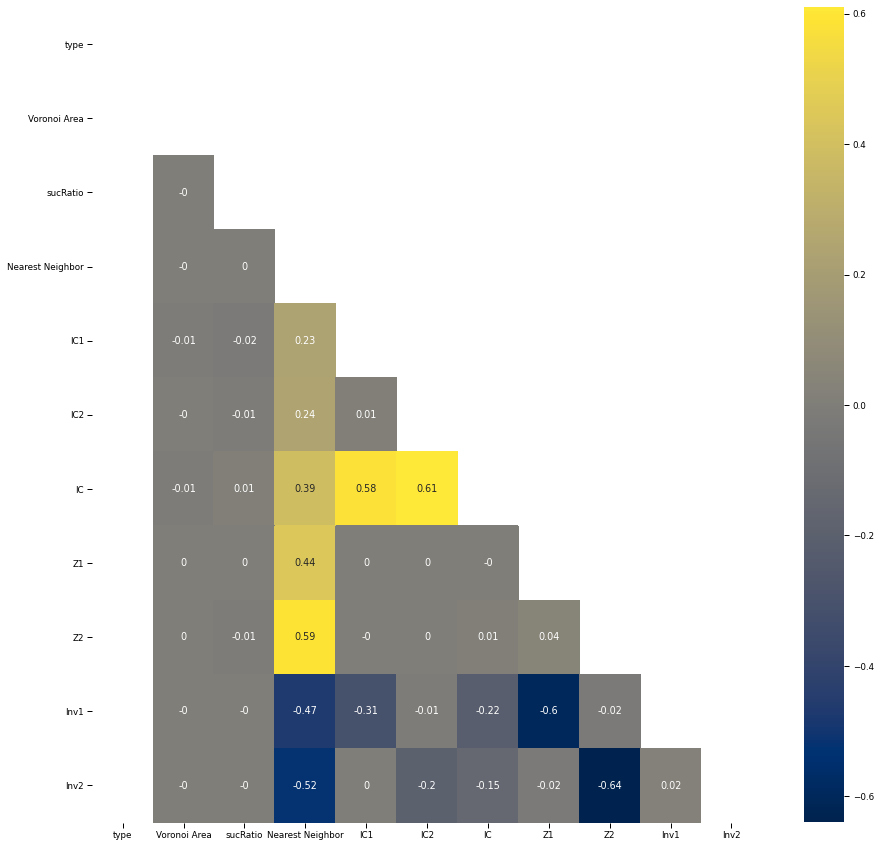

In [330]:
f, ax = plt.subplots(figsize=(15,15))
mask = np.zeros_like(train_X.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_X.corr().round(2), annot=True, mask=mask, cmap="cividis",ax=ax)

# Outlier detection using Cook’s distance plot

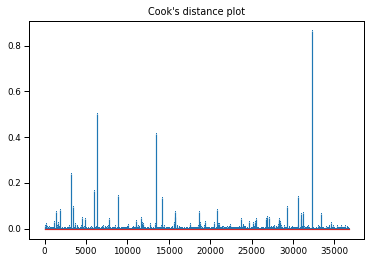

In [331]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence
f, ax = plt.subplots()
inf=influence(model)
(i, d) = inf.cooks_distance
ax.set_title("Cook's distance plot")
ax.stem(np.arange(len(i)), i, markerfmt=",")
plt.show()

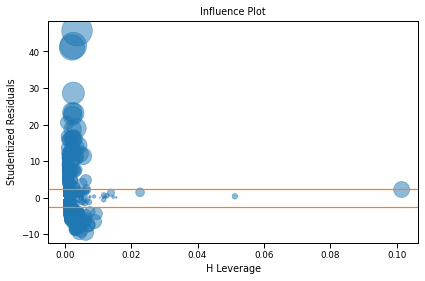

In [332]:
from statsmodels.stats.outliers_influence import OLSInfluence 
influence = OLSInfluence(model)
fig, ax = plt.subplots()
ax.axhline(-2.5, linestyle='-', color='C1')
ax.axhline(2.5, linestyle='-', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
 s=1000 * np.sqrt(influence.cooks_distance[0]),
 alpha=0.5)
ax.set_xlabel('H Leverage')
ax.set_ylabel('Studentized Residuals')
ax.set_title('Influence Plot')
plt.tight_layout()
plt.show()

In [333]:
""" f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show() """

" f, ax = plt.subplots()\n\nax.scatter(predictions,y)\nlims = [\n    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes\n    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes\n]\n\n# now plot both limits against eachother\nax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)\nax.set_aspect('equal')\nax.set_xlim(lims)\nax.set_ylim(lims)\nax.set_xlabel('Prediction')\nax.set_ylabel('Total biomass')\nplt.show() "

# Regression with scaled metrics

In [341]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

names=pd.DataFrame(train_X.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 3, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

  Feature  Rank
4     IC1     1
5     IC2     1
6      IC     1


C:\Users\Jonathan\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


3

In [342]:

model = sm.OLS(train_y,train_X[most_important['Feature']]).fit()
predictions = model.predict(test_X[most_important['Feature']])
df_results = pd.DataFrame({'Actual' : test_y, 'Predicted': predictions})

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.596
Model:                            OLS   Adj. R-squared (uncentered):              0.596
Method:                 Least Squares   F-statistic:                          1.809e+04
Date:                Mon, 20 Sep 2021   Prob (F-statistic):                        0.00
Time:                        13:48:24   Log-Likelihood:                     -4.9346e+05
No. Observations:               36748   AIC:                                  9.869e+05
Df Residuals:                   36745   BIC:                                  9.870e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

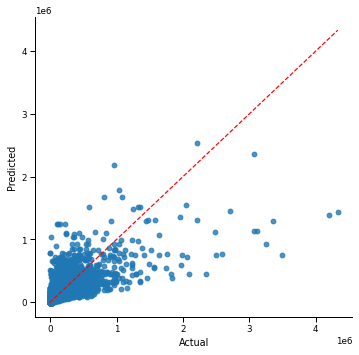

In [343]:
#Plot the actual vs predicted results
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
#Plot the diagonal line
d_line= np.arange(df_results.min().min(), df_results.max().max())
plt.plot(d_line, d_line, color='red', linestyle='--')
plt.show()